# Rail network exploration



## Goal
* Understand the BOF rail netwrok dataset. 
* Merge it with the intermodal data set.
* Simplify this merged dataset (remove unnecesary nodes).

In [2]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import collections
import osmnx as ox
from shapely.geometry import Polygon, LineString
import time
import re

import sys
sys.path.append('../../../Multimodal_freight_USA/')

from mfreight.utils import simplify

pd.set_option('display.max_columns', None)

## Import BOF data sets

In [2]:
start = time.time()

edges = gpd.read_file('../../mfreight/Rail/rail_data/North_American_Rail_Lines-shp/North_American_Rail_Lines.shp')
print(f'time elapsed: {time.time()-start}')

start = time.time()

nodes = gpd.read_file('../../mfreight/Rail/rail_data/North_American_Rail_Nodes-shp/North_American_Rail_Nodes.shp')
print(f'time elapsed: {time.time()-start}')

time elapsed: 24.22053098678589
time elapsed: 12.768944263458252


In [3]:
edges.head(2)

,OBJECTID,FRAARCID,FRFRANODE,TOFRANODE,STFIPS,CNTYFIPS,STCNTYFIPS,STATEAB,COUNTRY,FRAREGION,RROWNER1,RROWNER2,RROWNER3,TRKRGHTS1,TRKRGHTS2,TRKRGHTS3,TRKRGHTS4,TRKRGHTS5,TRKRGHTS6,TRKRGHTS7,TRKRGHTS8,TRKRGHTS9,SUBDIV,YARDNAME,PASSNGR,STRACNET,TRACKS,DIRECTION,CARDDIRECT,NET,MILES,KM,TIMEZONE,IM_RT_TYPE,DS,ShapeSTLen,geometry
0,1,300000,348741,348746,38,015,38015,ND,US,8,DMVW,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,2.0,None,M,0.178100,0.286624,C,None,None,418.656726,"LINESTRING (-100.74520 46.80284, -100.74508 46..."
1,2,300001,338567,338686,30,087,30087,MT,US,8,BNSF,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.0,NaN,None,O,0.887103,1.427657,M,None,None,2047.011640,"LINESTRING (-106.65758 45.86404, -106.65768 45..."


Source: https://data-usdot.opendata.arcgis.com/datasets/north-american-rail-lines-1

# Filter the data to keep only florida

<AxesSubplot:>

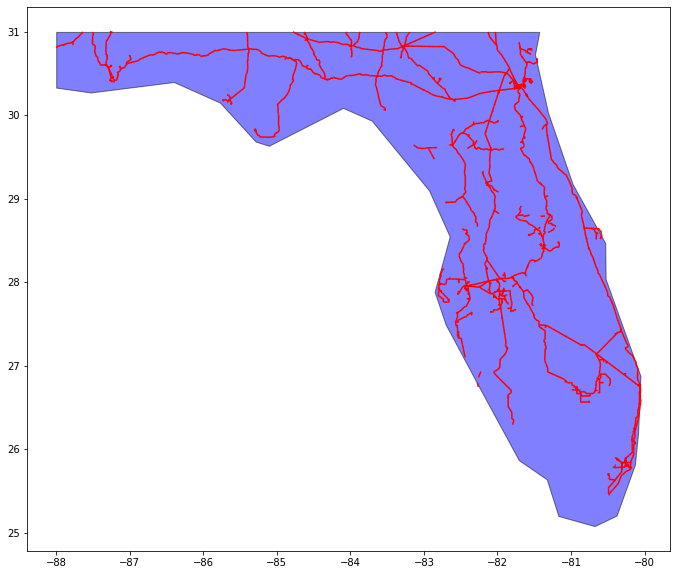

In [4]:
florida_polygon = Polygon([(-88, 24), (-88, 31), (-79, 31), (-79, 24)])

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
n_america = world[world["name"] == "United States of America"]

fig, ax = plt.subplots(figsize=(17,10))

florida_map = gpd.clip(n_america, florida_polygon)
florida_map.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)

edges = gpd.clip(edges, florida_polygon)
edges.plot(ax=ax, color="red")



## Format the geodataframes

In [5]:
def keep_only_valid_usa_rail(nodes, edges):

    edges = edges[edges.eval("(NET == 'I' | NET == 'M') &  COUNTRY == 'US'")]
    nodes = nodes[nodes.FRANODEID.isin(list(edges.u.values) + list(edges.v.values))]


def format_gpdfs(nodes, edges, inplace=True):
    
    start = time.time()
    if not inplace:
        nodes = nodes.copy()
        edges = edges.copy()

    edges.rename(columns={'FRFRANODE':'u','TOFRANODE':'v'}, inplace=True)
    edges['length'] = edges['KM']*1000
    edges['mode'] = 'rail'
    edges['CO2_eq_kg'] = pd.eval('edges.length /1000 * 0.0195254')
    edges['key'] = 0

    nodes['mode'] = 'rail'
    nodes['key'] = 0
    
    keep_only_valid_usa_rail(nodes, edges)
    nodes = nodes[nodes.FRANODEID.isin(list(edges.u.values) + list(edges.v.values))]

    edges.drop(columns=['YARDNAME','CNTYFIPS','STCNTYFIPS','STATEAB','COUNTRY','FRAREGION','SUBDIV','CARDDIRECT','MILES', 'KM','ShapeSTLen'],inplace=True)
    nodes.drop(columns=['OBJECTID','COUNTRY','STFIPS','CTYFIPS','FRAREGION','BNDRY','PASSNGR','PASSNGRSTN'],inplace=True)
    nodes.set_index('FRANODEID', drop=False, inplace=True)
    print(f'time elapsed: {time.time()-start}')

format_gpdfs(nodes, edges)

/Users/yann/.local/lib/python3.7/site-packages/pandas/core/computation/expr.py:631: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  v = getattr(resolved, attr)


time elapsed: 0.6205689907073975


/Users/yann/.local/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
edges.head(2)

,OBJECTID,FRAARCID,u,v,STFIPS,RROWNER1,RROWNER2,RROWNER3,TRKRGHTS1,TRKRGHTS2,TRKRGHTS3,TRKRGHTS4,TRKRGHTS5,TRKRGHTS6,TRKRGHTS7,TRKRGHTS8,TRKRGHTS9,PASSNGR,STRACNET,TRACKS,DIRECTION,NET,TIMEZONE,IM_RT_TYPE,DS,geometry,length,mode,CO2_eq_kg,key
151884,153512,451949,427983,427908,01,BAYL,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,2.0,M,C,None,None,"LINESTRING (-85.40443 31.00000, -85.40444 30.9...",4394.38678,rail,3.589570e-08,0
152371,153999,452436,440094,440126,13,CPR,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,2.0,M,E,None,None,"LINESTRING (-83.21542 30.96983, -83.21465 30.9...",1168.98611,rail,2.147979e-07,0


In [7]:
edges.TRACKS.value_counts()

0.0    2659
1.0    2180
2.0     167
Name: TRACKS, dtype: int64

This column is the track type, the FRA defined the tracktype as the speed at which trains can drive.
URL: https://en.wikipedia.org/wiki/Rail_speed_limits_in_the_United_States#Track_classes

One can observe many 0 Tracks. This is because there are many very short tracks in this data set (many of them are unused)

In [9]:
def add_speed_duration(edges):
    start = time.time()
    
    track_to_speed_map = {0:10,1:16,2:40,3:64,4:97,5:130,6:180,13:97}
    edges['speed_kmh'] = edges.TRACKS.replace(track_to_speed_map)
    edges['duration_h'] = pd.eval('edges.length * 1000 / edges.speed_kmh')
    print(f'time elapsed: {time.time()-start}')
    return edges
edges = add_speed_duration(edges)

time elapsed: 0.03685712814331055


Lets zoom in the Florida region to better understand the network 

In [10]:
def lane_filter_by_operator(shp_file, operators):
    # Filters the dataset, only keep the specified operators.
    
    mask = shp_lines.isin(operators).any(axis=1)
    filtered_shp_lines = shp_lines[mask]
    return filtered_shp_lines

## Adding the intermodal facilities

In [11]:
intermodal_nodes = gpd.read_file('../../mfreight/Rail/rail_data/Intermodal stations/Intermodal_Freight_Facilities_RailTOFCCOFC.shp')

In [12]:
intermodal_nodes.head(2)

,OBJECTID,TERMINAL,TERM_ADDRE,CITY,STATE,ZIP_CODE,PORT,DATE,RAIL_COMPA,EQUIPMENT,ACCESS_ROA,SPLC,LAT,LON,geometry
0,1,"Albany, NY - Mechanicville",50 Route 67,Mechanicville,NY,12118,None,2018-08-01,NS,COFC,None,171760,42.914715,-73.709533,POINT (-73.70953 42.91471)
1,2,"Albuquerque, NM",100 Woodward Road S.E.,Albuquerque,NM,87102,None,2018-09-01,BNSF,TOFC/COFC,None,774900,35.047580,-106.653344,POINT (-106.65334 35.04758)


In [13]:
def add_x_y_pos(gdf):
    start = time.time()
    pattern = re.compile(r'(-?\d+\.\d+)')

    coords = gdf.geometry.astype('str').str.extractall(pattern).unstack(level=-1)
    coords.columns = coords.columns.droplevel()
    coords.rename(columns={0: 'x', 1: 'y'}, inplace=True)
    gdf['x'] = coords.x.astype(float) #Carefull this only works for USA
    gdf['y'] = coords.y.astype(float)
    print(f'time elapsed: {time.time()-start}')

In [14]:
add_x_y_pos(intermodal_nodes)
add_x_y_pos(nodes)

time elapsed: 0.03957700729370117
time elapsed: 7.089777946472168


### Create a mapping from nodes to intermodal nodes

In [15]:
def map_rail_to_intermodal_nodes(intermodal_nodes, nodes_in):
    rail_node = []
    start = time.time()
    nodes.set_index('FRANODEID',drop=False,inplace=True)
    for row in intermodal_nodes.itertuples():
        dist = pd.eval('(nodes.x-row.x)**2 + (nodes.y-row.y)**2')
        rail_node.append(dist.idxmin())

    rail_to_intermodal_map = pd.Series(intermodal_nodes.OBJECTID.values, index=rail_node)
    print(f'time elapsed: {time.time()-start}')
    return rail_to_intermodal_map

intermodal_map = map_rail_to_intermodal_nodes(intermodal_nodes, nodes)

time elapsed: 0.8859171867370605


In [16]:
intermodal_map

491165      1
338596      2
357905      3
388695      4
430934      5
         ... 
320774    177
472362    178
449598    179
493551    180
363472    181
Length: 181, dtype: int64

In [17]:
nodes[nodes.FRANODEID == 455848]

,OBJECTID,FRANODEID,COUNTRY,STATE,STFIPS,CTYFIPS,STCYFIPS,FRAREGION,BNDRY,PASSNGR,PASSNGRSTN,geometry,mode,key,x,y
FRANODEID,,,,,,,,,,,,,,,,
455848,189146,455848,US,FL,12,009,12009,3,0,None,None,POINT (-80.72996 28.34538),rail,0,-80.729958,28.34538


In [18]:
edges[edges.v == 455848]

,OBJECTID,FRAARCID,u,v,STFIPS,RROWNER1,RROWNER2,RROWNER3,TRKRGHTS1,TRKRGHTS2,TRKRGHTS3,TRKRGHTS4,TRKRGHTS5,TRKRGHTS6,TRKRGHTS7,TRKRGHTS8,TRKRGHTS9,PASSNGR,STRACNET,TRACKS,DIRECTION,NET,TIMEZONE,IM_RT_TYPE,DS,geometry,length,mode,CO2_eq_kg,key,speed_kmh,duration_h
174116,175744,474182,455843,455848,12,FEC,None,None,SCXF,None,None,None,None,None,None,None,None,None,None,1.0,2.0,M,E,DS,NS-DS,"LINESTRING (-80.73129 28.34911, -80.72996 28.3...",432.78782,rail,7.737113e-08,0,16.0,0.247662


In [19]:
def add_intermodal_nodes(intermodal_map, nodes, edges):
    start = time.time()
    nodes.loc[:,'FRANODEID'].replace(intermodal_map, inplace=True)
    edges.loc[:,['u','v']] = edges.loc[:,['u','v']].replace(intermodal_map)
    print(f'time elapsed: {time.time()-start}')
    
    
add_intermodal_nodes(intermodal_map,nodes,edges)

time elapsed: 0.20406699180603027


In [20]:
G = ox.graph_from_gdfs(nodes, edges)

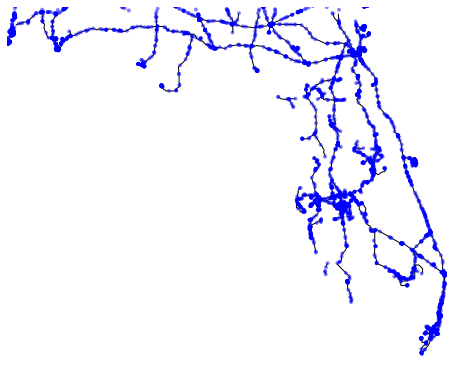

In [21]:
fig, ax = ox.plot_graph(G,node_color='blue',bgcolor='white',node_alpha=0.5,edge_color='black')

In [24]:
nodes_to_keep = list(nodes[nodes.index < 200].index)
attributes_to_sum = ['length','CO2_eq_kg','duration_h']
edges.drop('geometry',axis=1,inplace=True)
G = ox.graph_from_gdfs(nodes, edges)

G_s = simplify.simplify_graph(G,attributes_to_sum = attributes_to_sum,nodes_to_keep=nodes_to_keep)

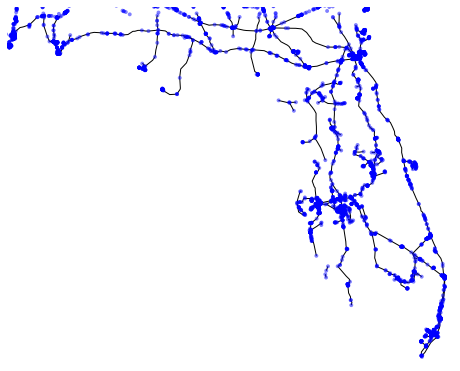

In [25]:
fig, ax = ox.plot_graph(G_s,node_color='blue',bgcolor='white',node_alpha=0.5,edge_color='black')

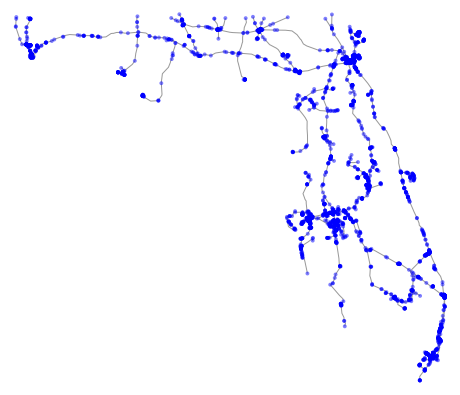

In [26]:
G_u = G_s.to_undirected()
largest_cc_nodes = max(nx.connected_components(G_u), key=len)
largest_cc = G_u.subgraph(largest_cc_nodes).copy()

fig, ax = ox.plot_graph(largest_cc,node_color='blue',bgcolor='white',node_alpha=0.5)

In [ ]:
nx.write_gpickle(largest_cc,'../../mfreight/Rail/rail_data/simplified_rail_net_florida.plk')

The whole data set has now been cleaned.

In [ ]:
edges.info()